# 2. Data Exploration and Preprocessing

In [1]:
import pandas as pd

# Loading dataset
dataset = pd.read_csv('train.csv')

# Dropping rows with missing content
dataset = dataset.dropna(subset=['content'])

glove_path = 'glove.6B.300d.txt'

debuggerEnabled = False

In [2]:
# Lowercase all the words
dataset['content'] = dataset['content'].str.lower()

In [3]:
# Emoji remover regex
import re

def remove_emojis(text):
    if text is None:
        return None
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002500-\U00002BEF"
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [4]:
# Stopwords Cleaner
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    if text is None:
        return None
    words = text.split()
    az_stopwords = stopwords.words('azerbaijani')
    filtered_text = ' '.join([word for word in words if word not in az_stopwords])
    return filtered_text if filtered_text.strip() != '' else None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/batuhansahin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Text Cleaner
''' 
    This function removes nones, links, non Turkish and Azerbaijani characters, number and punctuations
'''
import math

def clean_text(text):
    if text is None or isinstance(text, float) and math.isnan(text):
        return None
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zğüşıöçəĞÜŞİÖÇƏ\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    return text.strip() if text.strip() != '' else None

In [6]:
# Print dataset length before cleaning
if debuggerEnabled:
    print(len(dataset))

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# This pipeline will clean the text, remove stopwords and emojis

pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean_text))),
    ('stopwords_remover', FunctionTransformer(lambda x: x.apply(remove_stopwords))),
    ('cleaner_emojies', FunctionTransformer(lambda x: x.apply(remove_emojis))),
    ('dropna', FunctionTransformer(lambda x: x.dropna().reset_index(drop=True)))
])

# Applying the pipeline to the dataset content column and dropping rows with missing content
# Also resetting the index 
processed_data = pipeline.fit_transform(dataset['content']).dropna().reset_index(drop=True)

# Assigning the processed data to the dataset
dataset['content'] = processed_data
dataset = dataset.dropna().reset_index(drop=True)

In [8]:
# Print dataset length after cleaning
if debuggerEnabled:
    print(len(dataset))

In [9]:
# Divide the score column by 5 to get the sentiment value
dataset['sentiment'] = dataset['score'] / 5

# Update the sentiment column to 0 if the value is less than 0.5, otherwise 1
# dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 0 if x < 0.5 else 1)

# Show the first 20 rows of the dataset
if debuggerEnabled:
    print(dataset[:20])

In [10]:
print(dataset[66:77])

                                              content  score  upvotes  \
66  adreslər qeyd edilə bilmir çoxlu səhvlər çıxır...      3        7   
67                            gah işləyir gah işləmir      5        0   
68                                              super      5        0   
69                                              super      3        2   
70               eladi bezi tekmillestirmeler lazimdi      5        0   
71     hesab qara siyahiya salinib yazilir ne demekdi      1       18   
72  menim nomremede kanpaniya gelse yaxsi tetbik e...      1        0   
73                                      super tez tez      5        0   
74                   allah cıxaranın canın sağ eləsin      5        0   
75            ela cox razi qaldim ey den yawasin bolt      5        0   
76                                                əla      1        0   

    sentiment  
66        0.6  
67        1.0  
68        1.0  
69        0.6  
70        1.0  
71        0.2  
72        0

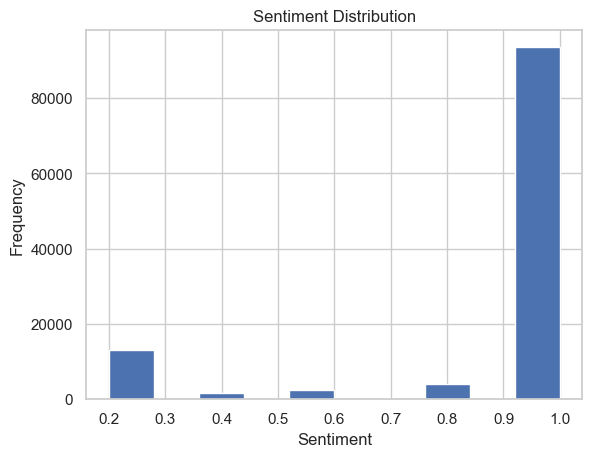

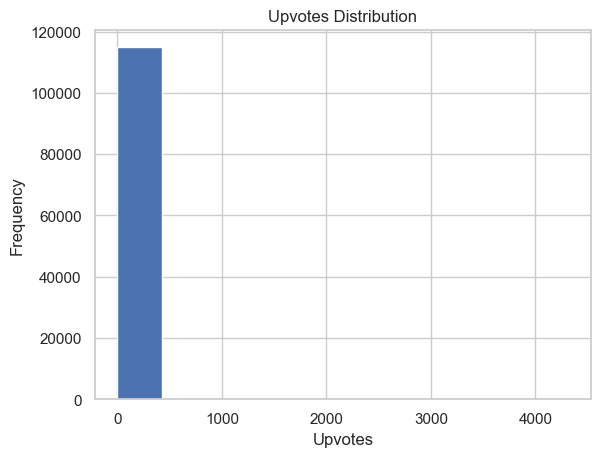

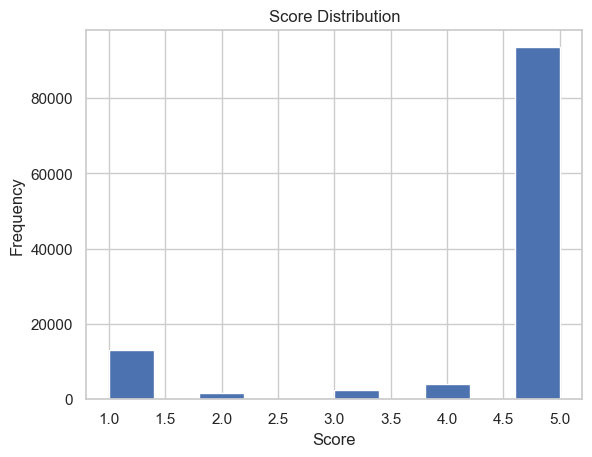

In [11]:
# Visualize data distributions (e.g., sentiment scores, upvote distribution).
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plotting the sentiment distribution
plt.hist(dataset['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

# Plotting the upvotes distribution
plt.hist(dataset['upvotes'])
plt.xlabel('Upvotes')
plt.ylabel('Frequency')
plt.title('Upvotes Distribution')
plt.show()

# Plotting the score distribution
plt.hist(dataset['score'])
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.show()

<h3><ul> 
Initial Findings

<li> 
There were words that started with a capital letter so we lowercased all of the dataset
</li>

<li> 
We found unnecessary characters like emojis, non Turkish or Azerbaijani words, links, numbers, punctuations and nones in the dataset.
</li>

<li>
There were some sentences that have punctuations between words without any whitespace
</li>

</ul></h3>

# Data Preparation

In [12]:
# Duplicate rows with upvotes more than 0
def duplicate_rows(row):
    return pd.concat([row] * row['upvotes'], ignore_index=True)

# repeated_indices = dataset.index.repeat(dataset['upvotes'] + 1) 

# Assigning the repeated rows to the dataset
# dataset = dataset.loc[repeated_indices].reset_index(drop=True) 

if debuggerEnabled:
    print(len(dataset))

In [13]:
# Split the dataset into sentiment and content
sentiment = dataset['sentiment'].values.tolist()
content = dataset['content'].values.tolist()

In [14]:
# Split the dataset into training and testing sets
split_point = int(len(content) * 0.80)
train_content, test_content = content[:split_point], content[split_point:]
train_sentiment, test_sentiment = sentiment[:split_point], sentiment[split_point:]

train_dataset, test_dataset = dataset[:split_point], dataset[split_point:]

print(len(train_content), len(test_content))

91947 22987


With a sufficient amount of data in both the training and testing sets, statistical metrics such as accuracy, precision, recall, and F1 score computed on the testing set are more likely to provide meaningful insights into the model's performance.

# Tokenization

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
# Tokenize the text data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(content)

# Display the word index
# tokenizer.word_index

# Convert text data to sequences
train_tokens = tokenizer.texts_to_sequences(train_content)

# Display tokenized data
if debuggerEnabled:
    print(train_content[800])
    print(train_tokens[800])

# Tokenize test data
test_tokens = tokenizer.texts_to_sequences(test_content)

In [17]:
# Tokenization with NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

def tokenize_text_nltk(text):
    if text is None:
        return None
    return word_tokenize(text)

def tokenize_text_nltk_sentence(text):
    if text is None:
        return None
    return sent_tokenize(text)

In [18]:
# Tokenization with Spacy
import spacy
import xx_sent_ud_sm

# Must run in terminal "python -m spacy download xx_sent_ud_sm"

spacy_data = spacy.load("xx_sent_ud_sm")
spacy_nlp = xx_sent_ud_sm.load()

def tokenize_text_spacy(text):
    if text is None:
        return None
    doc = spacy_nlp(text)
    return [token.text for token in doc]

In [19]:
# Tokenization with Polyglot
from polyglot.text import Text
def tokenize_text_polyglot(text, language_code='tr'):
    if text is None:
        return None
    try:
        polyglot_text = Text(text, hint_language_code=language_code)
        return [token for token in polyglot_text.words]
    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None



In [20]:
def tokenization_operations(tokinization_name,train_content, test_content):
    print(len(train_content))
    if tokinization_name == 'spacy':
        train_tokens = train_content.apply(lambda x: tokenize_text_spacy(x) if x is not None else None)
        test_tokens = test_content.apply(lambda x: tokenize_text_spacy(x) if x is not None else None)
    if tokinization_name == 'nltk':
        train_tokens = train_content.apply(lambda x: tokenize_text_nltk(x))
        test_tokens = test_content.apply(lambda x: tokenize_text_nltk(x))
    if tokinization_name == 'polyglot':
        train_tokens = train_content.apply(lambda x: tokenize_text_polyglot(x) if x is not None else None)
        test_tokens = test_content.apply(lambda x: tokenize_text_polyglot(x) if x is not None else None)

    if debuggerEnabled:
        print("Tokenized Training Data Examples:", train_tokens.head())
        print("Tokenized Test Data Examples:", test_tokens.head())
        
    return train_tokens, test_tokens

In [21]:
# Tokenize the text data with NLTK
train_token_nltk, test_token_nltk = tokenization_operations('nltk', train_dataset['content'], test_dataset['content'])
print(len(train_token_nltk), len(test_token_nltk))

91947
91947 22987


In [22]:
# Tokenize the text data with Spacy
test_token_spacy, train_token_spacy = tokenization_operations('spacy', train_dataset['content'], test_dataset['content'])

91947


In [23]:
# Tokenize the text data with Polyglot
test_token_polyglot, train_token_polyglot = tokenization_operations('polyglot', train_dataset['content'], test_dataset['content'])

91947


<h3><ul> 
Comparison of Results

<li> 
Fastest tokenizer was the NLTK
</li>

<li> 
We had some issues while installing polyglot on our computers
</li

</ul></h3>

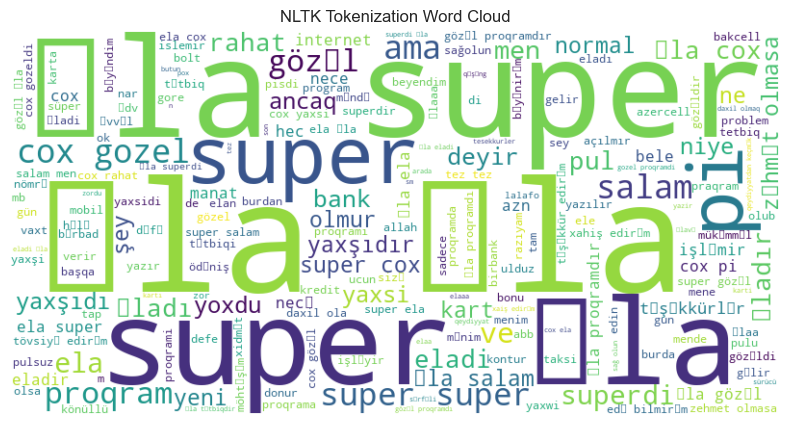

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten the list of lists
flat_tokens = [token for sublist in train_token_nltk for token in sublist]

# Convert token list to string
text = ' '.join(flat_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('NLTK Tokenization Word Cloud')
plt.axis('off')
plt.show()


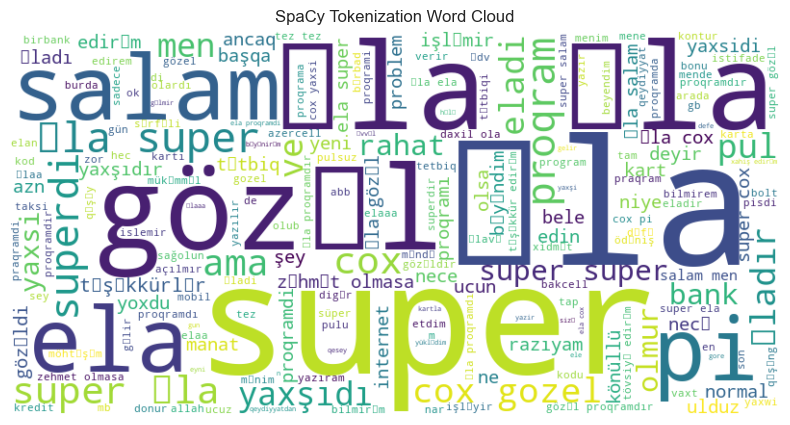

In [25]:
# Flatten the list of lists
flat_tokens = [token for sublist in train_token_spacy for token in sublist]

# Convert token list to string
text = ' '.join(flat_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('SpaCy Tokenization Word Cloud')
plt.axis('off')
plt.show()


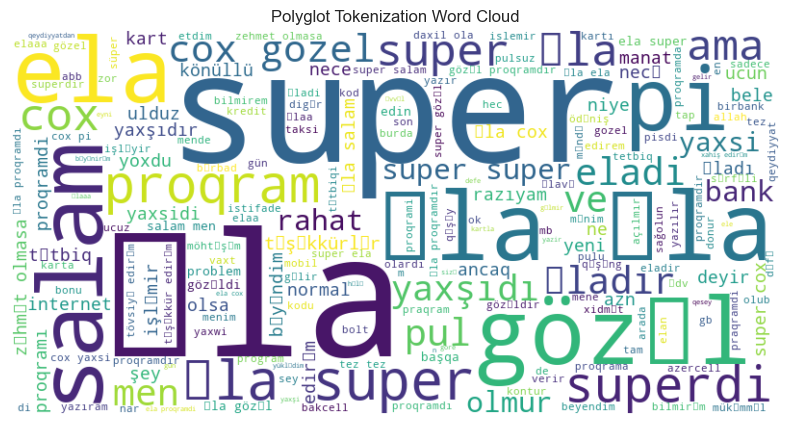

In [26]:
# Flatten the list of lists
flat_tokens = [token for sublist in train_token_polyglot for token in sublist]

# Convert token list to string
text = ' '.join(flat_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Polyglot Tokenization Word Cloud')
plt.axis('off')
plt.show()


In [27]:
import numpy as np

# Calculate and display token statistics
num_tokens = [len(tokens) for tokens in train_tokens + test_tokens]
num_tokens = np.array(num_tokens)
print("Mean number of tokens:", np.mean(num_tokens))
print("Max number of tokens:", np.max(num_tokens))
print("Index of max tokens:", np.argmax(num_tokens))

# Set the maximum number of tokens based on mean and standard deviation
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
max_tokens

Mean number of tokens: 3.6425513773121967
Max number of tokens: 188
Index of max tokens: 101208


13

In [28]:
# Pad the sequences
train_tokens_pad = pad_sequences(train_tokens, maxlen=max_tokens)
test_tokens_pad = pad_sequences(test_tokens, maxlen=max_tokens)
print(train_tokens_pad.shape)
print(test_tokens_pad.shape)

(91947, 13)
(22987, 13)


In [29]:
# Create a mapping from index to word
word_index = tokenizer.word_index
inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [30]:
# Define a function to convert tokens back to text
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = ' '.join(words)
    return text

In [31]:
# Display an example of converting tokens to text
print(train_content[800])
print(tokens_to_string(train_tokens[800]))

faizleride yazsaniz super hansi kartdan hansi karya ne qeder tutacaq
super hansi kartdan hansi ne qeder


In [32]:
# Build the sequential model
model = Sequential()

In [33]:
# Set embedding size
embedding_size = 50

In [34]:
# Add embedding layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    name='embedding_layer'))

In [35]:
# Add GRU layers
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))

In [36]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train the model
train_sentiment = np.array(train_sentiment)
trained_history = model.fit(train_tokens_pad, train_sentiment, epochs=10, batch_size=256)

Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8070 - loss: 0.3811
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8144 - loss: 0.3580
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8129 - loss: 0.3576
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8157 - loss: 0.3503
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8137 - loss: 0.3497
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8135 - loss: 0.3459
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8141 - loss: 0.3424
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8151 - loss: 0.3350
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8158 - loss: 0.3239
Epoch 10/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8131 - loss: 0.3187


In [39]:
# Evaluate the model on the test set
test_sentiment = np.array(test_sentiment)
evaluation_result = model.evaluate(test_tokens_pad, test_sentiment)
print("Test accuracy:", evaluation_result[1])

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8012 - loss: 0.3822
Test accuracy: 0.802279531955719


In [40]:
# Make predictions on a sample of data
sample_predictions = model.predict(x=test_tokens_pad[0:1000]).T[0]
predicted_classes = np.array([1.0 if p > 0.5 else 0.0 for p in sample_predictions])
true_classes = np.array(test_sentiment[0:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [41]:
# Identify incorrect predictions
incorrect_predictions = np.where(predicted_classes != true_classes)[0]
print("Number of incorrect predictions:", len(incorrect_predictions))

Number of incorrect predictions: 203


In [42]:
# Display an example of incorrect prediction
sample_index = incorrect_predictions[66]
print("Index of incorrect prediction:", sample_index)
print("Text:", test_content[sample_index])
print("Predicted Rating:", sample_predictions[sample_index])
print("True Rating:", true_classes[sample_index])

Index of incorrect prediction: 365
Text: super
Predicted Rating: 0.88426566
True Rating: 0.6


In [43]:
# Make predictions on new sample texts
new_texts = ["Proqrama girmek olmur donub qalib bu ne meseledi?"]
new_tokens = tokenizer.texts_to_sequences(new_texts)
new_tokens_pad = pad_sequences(new_tokens, maxlen=max_tokens)
print("Predictions for new texts:\n", model.predict(new_tokens_pad))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predictions for new texts:
 [[0.9722825]]


# Glove

In [44]:
import tensorflow as tf

# Load the GloVe embeddings
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix_glove = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_glove[i] = embedding_vector

glove_model = Sequential([
    Embedding(num_words, 300, 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_glove),
              input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])

# Compile the model
glove_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
train_sentiment = np.array(train_sentiment)
history_glove=glove_model.fit(train_tokens_pad, train_sentiment, epochs=5, batch_size=256)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7994 - loss: 0.4221
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8137 - loss: 0.3587
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8130 - loss: 0.3590
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8137 - loss: 0.3577
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8135 - loss: 0.3584


# Word2Vec

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from gensim.models import KeyedVectors

# Load Word2Vec embeddings
model_path = 'GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)

words = word_vectors.index_to_key

embedding_matrix_w2v = np.zeros((num_words, word_vectors.vector_size))
for word, i in word_index.items():
    if i < num_words:
        if word in word_vectors:
            embedding_matrix_w2v[i] = word_vectors[word]
 
# Define the model
model = Sequential([
    Embedding(num_words, word_vectors.vector_size,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_w2v),
              input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])
 
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
# Assuming train_tokens_pad and train_sentiment are defined and properly shaped
train_sentiment = np.array(train_sentiment)
history_w2v = model.fit(train_tokens_pad, train_sentiment, epochs=5, batch_size=256)

Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8044 - loss: 0.4402
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8155 - loss: 0.3579
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8147 - loss: 0.3582
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8151 - loss: 0.3560
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8152 - loss: 0.3567


# SVD

In [46]:
from scipy.linalg import svd

# Perform SVD
U, S, VT = svd(embedding_matrix_w2v, full_matrices=False)

# Select the number of components you want to keep
num_features = min(50, len(words))
U_reduced = U[:, :num_features]

# Initialize a new embedding matrix with reduced dimensions
embedding_matrix_SVD = np.zeros((len(words), num_features))
print(num_features, "features selected")
print(len(words))

# Update the embedding matrix with reduced dimensions
actual_num_words = min(len(words), U.shape[0])

for i in range(actual_num_words):
    embedding_matrix_SVD[i] = U_reduced[i]

def train_generator():
    for tokens, rating in zip(train_tokens_pad, train_sentiment):
        yield tokens, rating

# Assuming train_tokens_pad and train_sentiment are numpy arrays
train_data = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(64).prefetch(tf.data.AUTOTUNE)

history_svd=model.fit(train_data, epochs=5)

50 features selected
3000000
Epoch 1/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8144 - loss: 0.3582
Epoch 2/5
  26/1437 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7896 - loss: 0.3847

2024-05-07 02:08:30.860230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1437/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8144 - loss: 0.3582
Epoch 3/5
  25/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7891 - loss: 0.3851 

2024-05-07 02:08:39.863470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1437/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8144 - loss: 0.3582
Epoch 4/5
  26/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7896 - loss: 0.3847

2024-05-07 02:08:49.078121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1437/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8144 - loss: 0.3582
Epoch 5/5
  25/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7891 - loss: 0.3850

2024-05-07 02:08:57.978424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1437/1437 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8144 - loss: 0.3582


2024-05-07 02:09:06.965323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Polyglot

In [47]:
from polyglot.downloader import downloader
downloader.download("embeddings2.az")

[polyglot_data] Downloading package embeddings2.az to
[polyglot_data]     /Users/batuhansahin/polyglot_data...
[polyglot_data]   Package embeddings2.az is already up-to-date!


True

In [48]:
from polyglot.mapping import Embedding
from tensorflow.keras.layers import Embedding as KerasEmbedding

# Load Polyglot embeddings
polyglot_embeddings = Embedding.load("./embeddings_pkl.tar.bz2")

# Create an embedding matrix
embedding_matrix_polyglot = np.zeros((num_words, polyglot_embeddings.shape[1]))

# Napping from word to integer index
for word, i in word_index.items():
    if i < num_words:
        try:
            embedding_vector = polyglot_embeddings[word]
            embedding_matrix_polyglot[i] = embedding_vector
        except KeyError:
            continue

# Define the model
model = Sequential([
    KerasEmbedding(input_dim=num_words, output_dim=polyglot_embeddings.shape[1],
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_polyglot),
                   input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_sentiment = np.array(train_sentiment)
history_polyglot=model.fit(train_tokens_pad, train_sentiment, epochs=5, batch_size=256)

Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8052 - loss: 0.4234
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8134 - loss: 0.3602
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8139 - loss: 0.3596
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8143 - loss: 0.3576
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8163 - loss: 0.3538


# FastText

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Load FastText embeddings
def load_fasttext_embeddings(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Path for FastText embeddings file
embeddings_path = 'cc.az.300.vec'
embeddings_index = load_fasttext_embeddings(embeddings_path)
max_words=num_words

# Mapping words to their integer indices and 'max_words'
embedding_matrix_fastText = np.zeros((max_words, 300))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_fastText[i] = embedding_vector

# Define the model
model = Sequential([
    Embedding(max_words, 300, weights=[embedding_matrix_fastText], input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assume 'train_padded' is the padded sequence of training data and 'train_labels' are the labels
# Train the model
history_fastText = model.fit(train_tokens_pad, train_sentiment, epochs=5, batch_size=256)


Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7949 - loss: 0.4324
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8156 - loss: 0.3573
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8139 - loss: 0.3591
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8167 - loss: 0.3548
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8124 - loss: 0.3592


# Plot Models

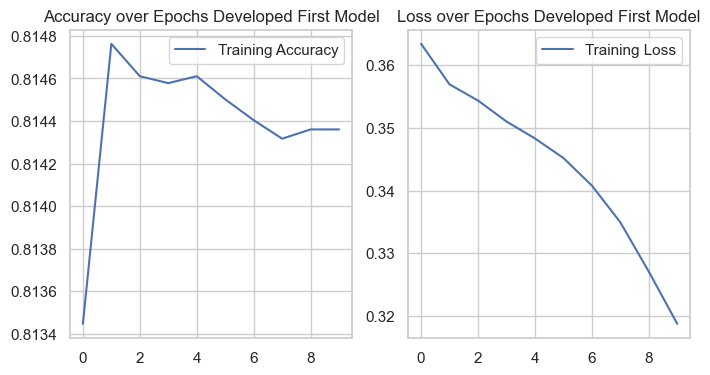

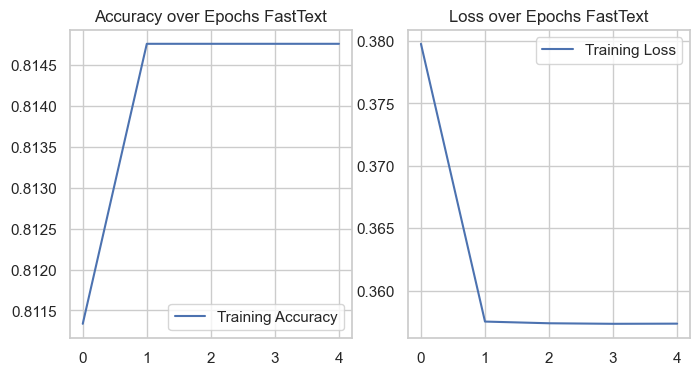

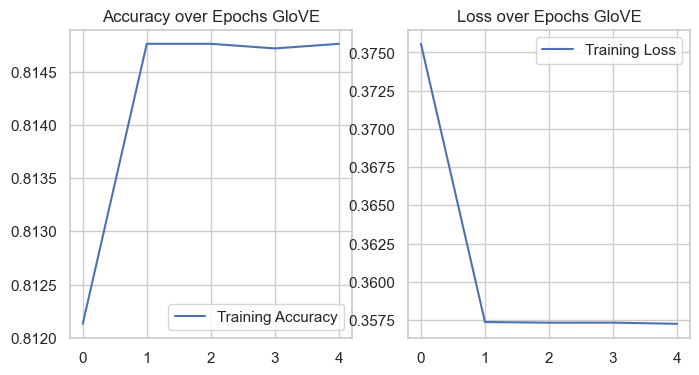

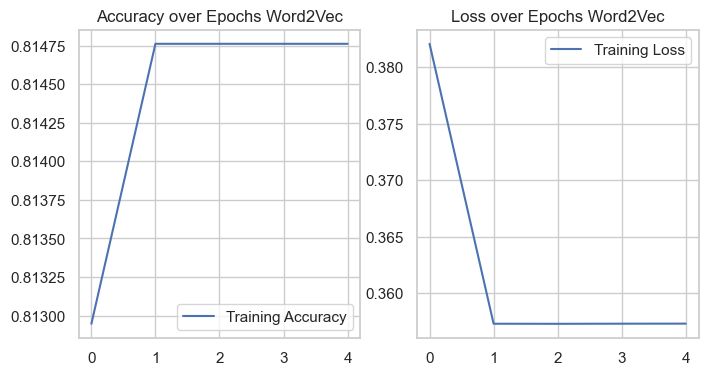

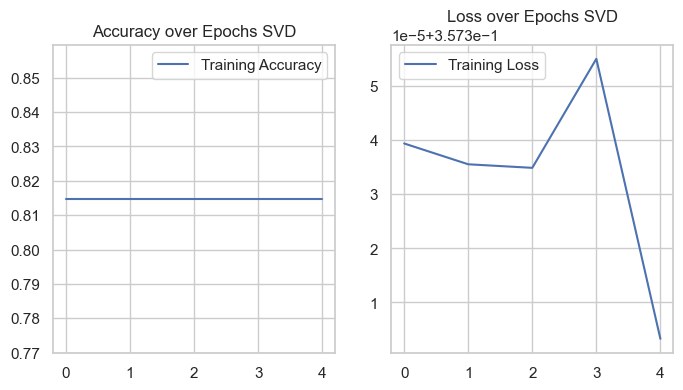

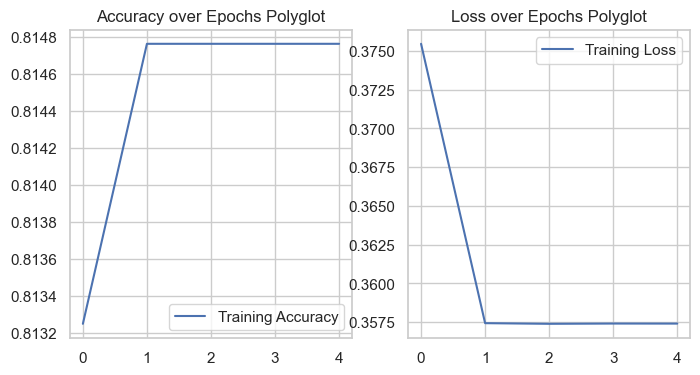

In [50]:
import matplotlib.pyplot as plt

def plot_models(history,name):
    # Plotting training and validation accuracy
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy over Epochs '+ name)
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss over Epochs '+ name)
    plt.legend()

    plt.show()
    

plot_models(trained_history,"Developed First Model")
plot_models(history_fastText,"FastText")
plot_models(history_glove,"GloVE")
plot_models(history_w2v,"Word2Vec")
plot_models(history_svd,"SVD")
plot_models(history_polyglot,"Polyglot")

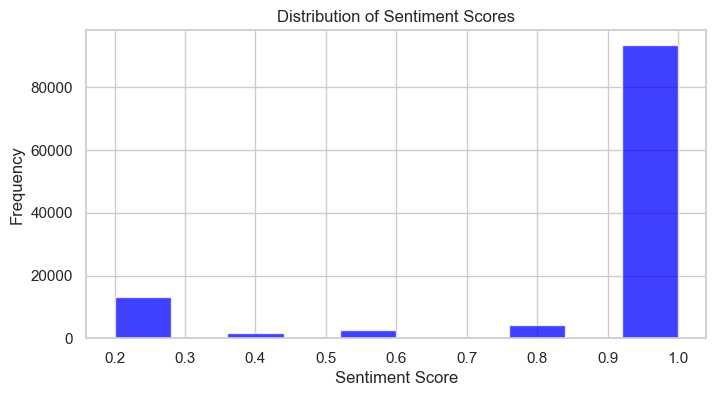

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
df = pd.DataFrame(dataset['sentiment'])

# Plotting the distribution of sentiment scores
plt.figure(figsize=(8, 4))
plt.hist(df['sentiment'], bins=10, alpha=0.75, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


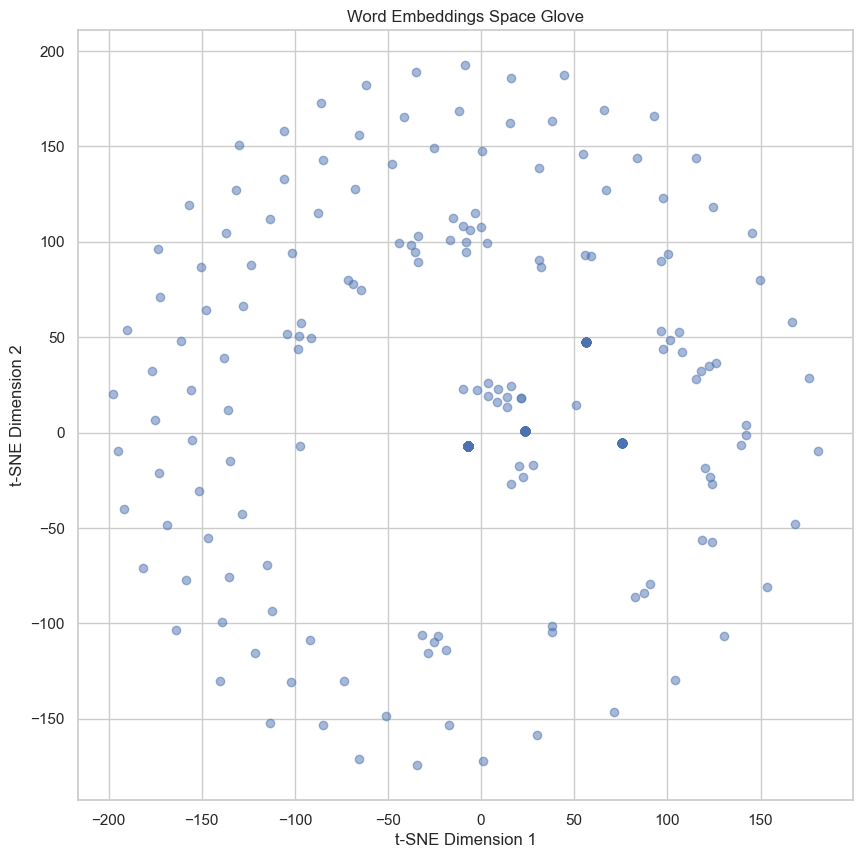

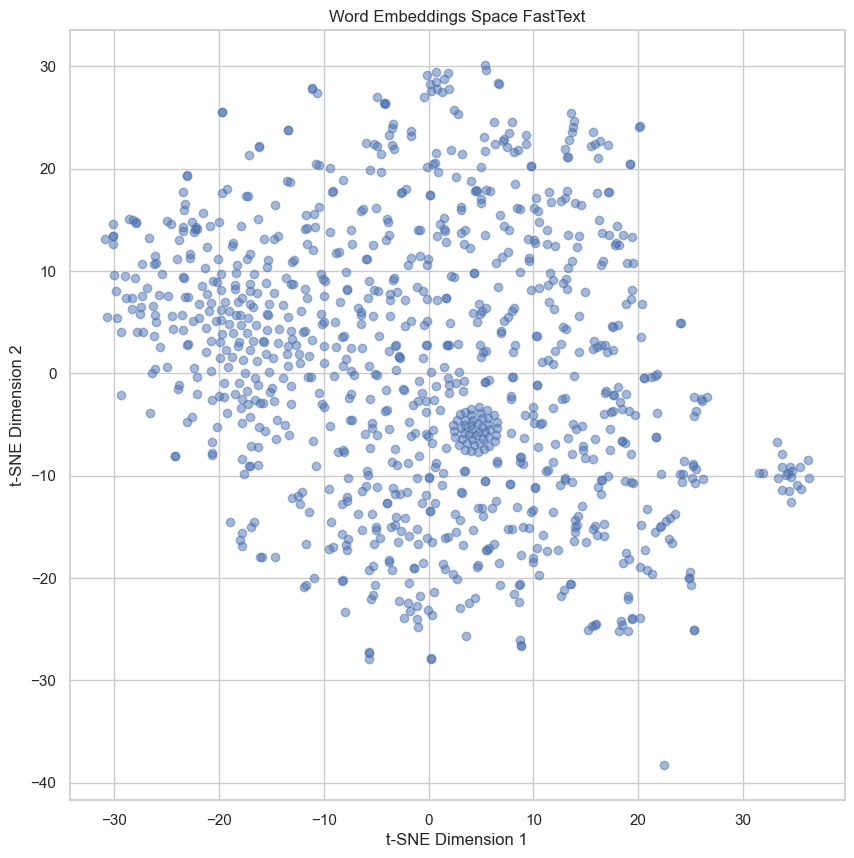

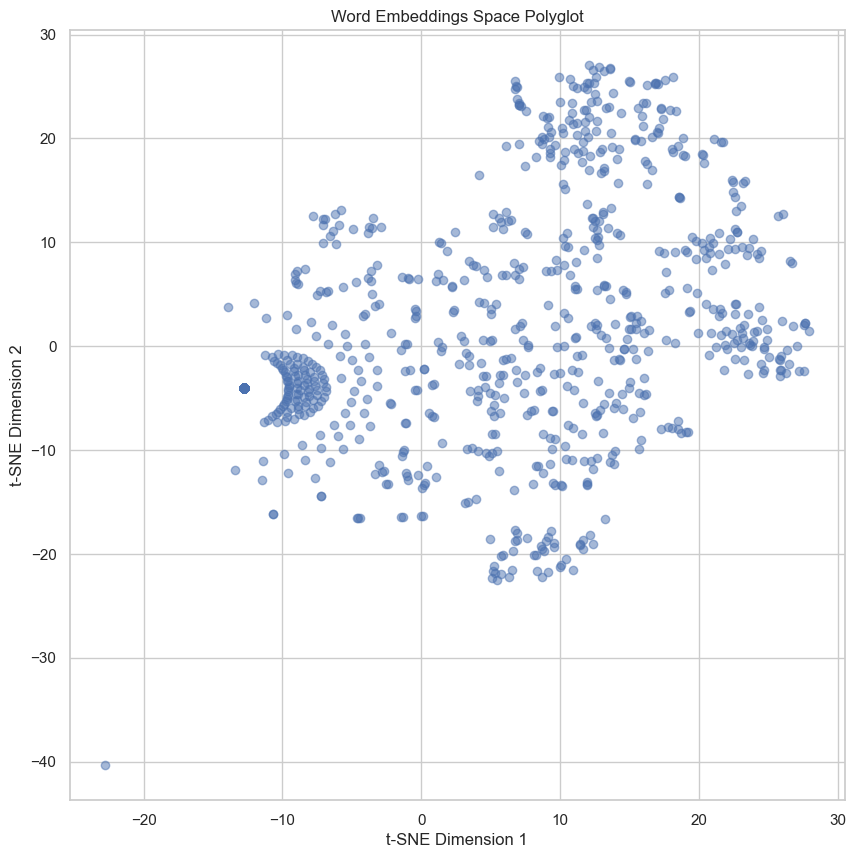

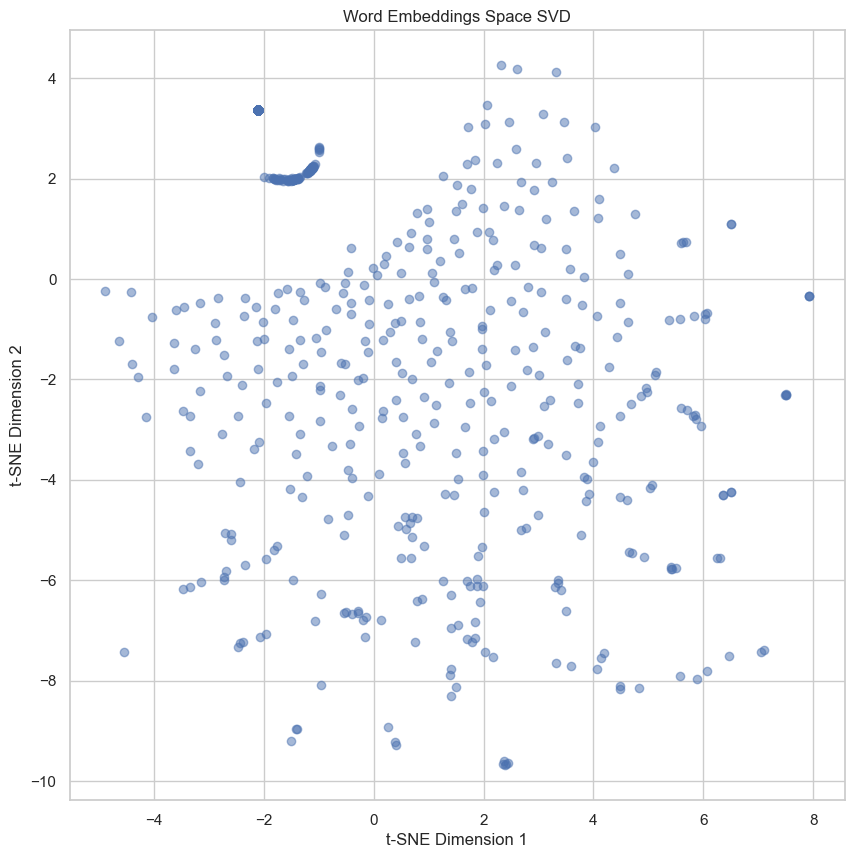

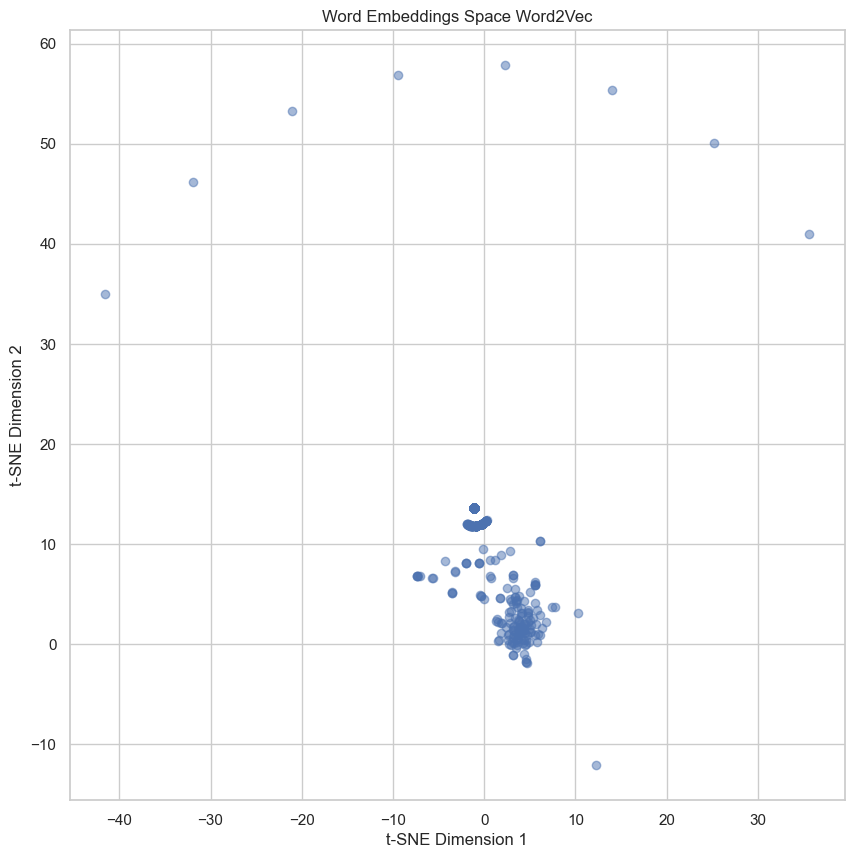

In [52]:
from sklearn.manifold import TSNE

# Assuming 'embedding_matrix' is your matrix of word embeddings
# Let's say it's shaped 10000x300 (10000 words, each with a 300-dimensional embedding)
def embedding_space(embedding_matrix,name):
# Using t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embedding_matrix[:1000])  # Using only the first 1000 for speed

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
    plt.title('Word Embeddings Space '+name)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
embedding_space(embedding_matrix_glove, "Glove")
embedding_space(embedding_matrix_fastText, "FastText")
embedding_space(embedding_matrix_polyglot, "Polyglot")
embedding_space(embedding_matrix_SVD,"SVD")
embedding_space(embedding_matrix_w2v,"Word2Vec")